<a href="https://colab.research.google.com/github/mashasiri/LLM_SDAIA1/blob/main/Mashael_Arabic_hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hate Speech Detection with AraBERT and HuggingFace
In this assignment, we will be exploring the application of the AraBERT model specifically for the task of hate speech detection. We will use the AJGT Sentiment Analysis dataset from K. M. Alomari, H. M. ElSherif, and K. Shaalan, “Arabic tweets sentimental analysis using machine learning,” in Proceedings of the International Conference on Industrial, Engineering and Other Applications of Applied Intelligent Systems, pp. 602–610, Montreal, Canada, June 2017.


# Check which GPU we have

In [30]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu Mar 28 16:49:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

##Installing Prerequisites

In [31]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

fatal: destination path 'arabert' already exists and is not an empty directory.


#Reading Data
We will rely on the following libraries for training and evaluation:

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
!git clone https://github.com/komari6/Arabic-twitter-corpus-AJGT.git

fatal: destination path 'Arabic-twitter-corpus-AJGT' already exists and is not an empty directory.


**Question 1:** Read the dataset and arrange the columns name using the set variables:

In [34]:

# Read the dataset
data = pd.read_excel('Arabic-twitter-corpus-AJGT/AJGT.xlsx')

# Define the column names
DATA_COLUMN = 'Feed'
LABEL_COLUMN = 'Sentiment'
INDEX_COLUMN = 'Index'

# Rename the columns
data.columns = [INDEX_COLUMN, DATA_COLUMN, LABEL_COLUMN]

**Question 2**: Split the data into training and testing (80-20)

In [41]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[DATA_COLUMN], data[LABEL_COLUMN], test_size=0.20, random_state=42)


**Question 3:** Plot the distribution of lengths of sentences in both training and test set. Extract the max_len value to be used later:

Training Sentence Lengths:


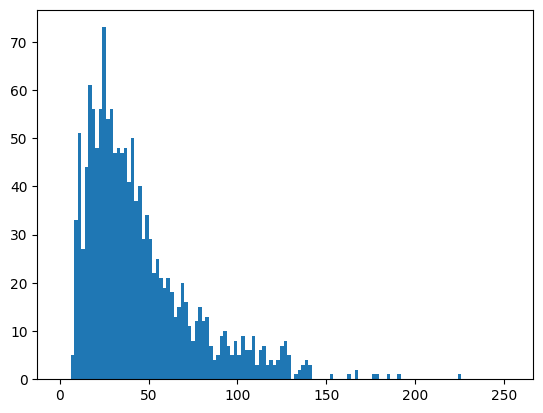

3
Test Sentence Lengths :


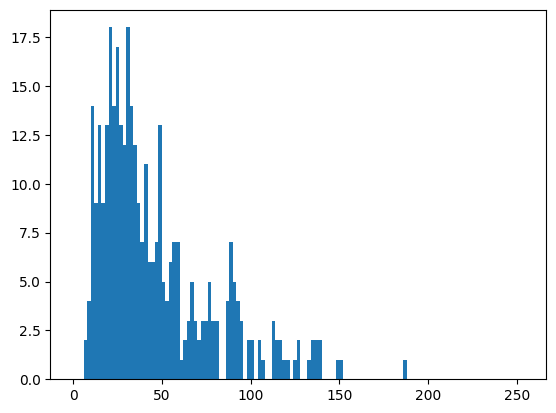

5


In [42]:
print("Training Sentence Lengths:")
plt.hist([len(sentence) for sentence in mydf_train['text']], bins=range(0,256,2))
plt.show()
print (sum([len(sentence)>256 for sentence in mydf_train['text']]))
print ("Test Sentence Lengths :")
plt.hist([len(sentence) for sentence in mydf_test ['text']], bins=range(0,256,2 ))
plt.show()
print (sum([len(sentence)> 256 for sentence in mydf_test ['text']]))
#X-axis: Sentence lengths (number of characters) .
#Y-axis: Frequency of sentences within each length range.

We can conclude that the max_len can be chosen to be ___.

#Training Requirements

Let's start by creating the dataset needed for training and testing, we will use the Dataset class from pytorch as our base class.

For tokenization, we will be using the autotokenizer from HuggingFace.

In [43]:

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.data.processors.utils import InputFeatures
from transformers import AutoTokenizer

#define the Dataset class
class SADataset(Dataset):
  def __init__(self, texts, labels, model_name, max_len, label_map):
    #hold the text and reviews inside the dataset class
    self.texts = texts
    self.labels = labels
    self.label_map = label_map
    self.tokenizer_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_len = max_len

  def __len__(self):
    #returns the length of the dataset
    return len(self.texts)

  def __getitem__(self, item):
    # Select the example based on the item ID
    text = str(self.texts[item])
    label = self.labels[item]

    input_dict = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding = 'max_length',
          truncation= True
      )

    return InputFeatures(input_ids=input_dict["input_ids"],
                         token_type_ids=input_dict['token_type_ids'],
                         attention_mask=input_dict["attention_mask"],
                         label=self.label_map[self.labels[item]])
# Define the model_name, max_len, and label_map variables
model_name = "bert-base-uncased"
max_len = 120

**Question 4:** Define the evaluation metrics that we will need, including `accuracy_score`, `f1_score`, `precision_score` and `recall_score` from sklearn.

In [44]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    assert len(preds) == len(pred.label_ids)

    # Check if the pos_label is a valid label
    pos_label = 1  # Assuming the positive label is represented by 1

    if pos_label not in set(pred.label_ids):
        raise ValueError(f"Invalid pos_label: {pos_label}. Valid labels are {set(pred.label_ids)}.")

    macro_f1 = f1_score(pred.label_ids, preds, average='macro')
    macro_f1_pos_neg = f1_score(pred.label_ids, preds, average='binary', pos_label=pos_label)  # Use the specified pos_label
    macro_precision = precision_score(pred.label_ids, preds, average='macro')
    macro_recall = recall_score(pred.label_ids, preds, average='macro')
    acc = accuracy_score(pred.label_ids, preds)

    return {
        'macro_f1': macro_f1,
        'macro_f1_pos_neg': macro_f1_pos_neg,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': acc
    }

## Preprocess the dataset
Let's start by defining the AraBERT preprocessor:

In [45]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/bert-base-arabertv02'
arabert_prep = ArabertPreprocessor(model_name)


**Question 5:** Apply preprocessing for the text column using the arabert preprocessor:

In [46]:

# Applying the arabert preprocessor to the 'text' column
X_train = X_train.apply(lambda x: arabert_prep.preprocess(x))
X_test = X_test.apply(lambda x: arabert_prep.preprocess(x))

Let's extract the label to id map:

In [47]:
label_list = list(data['Sentiment'].unique())
label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

{'Positive': 0, 'Negative': 1}


**Question 6:** Create the train and test SADataset:

In [48]:
# Defining the SADataset class
class SADataset(Dataset):
    def __init__(self, texts, labels, model_name, max_len, label_map):
        self.texts = texts
        self.labels = labels
        self.label_map = label_map
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        input_dict = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_len,
                                                padding='max_length', truncation=True, return_tensors='pt')

        return {
            'input_ids': input_dict["input_ids"].squeeze(),
            'token_type_ids': input_dict['token_type_ids'].squeeze(),
            'attention_mask': input_dict["attention_mask"].squeeze(),
            'label': self.label_map[label]
        }


In [49]:

train_dataset = SADataset(texts=X_train.tolist(), labels=y_train.tolist(), model_name=model_name,
                          max_len=max_len, label_map=label_map)

test_dataset = SADataset(texts=X_test.tolist(), labels=y_test.tolist(), model_name=model_name,
                         max_len=max_len, label_map=label_map)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Setup the HuggingFace trainer

We will be using the `bert-base-arabertv02` from HuggingFace models by Antoun et Al (2020). We can choose other Arabic BERT models by just changing the path here from `https://huggingface.co/models`.

In [50]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can now set up the training arguments, you can more information from https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [51]:
from transformers import Trainer , TrainingArguments

training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 4,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_macro_f1',
    greater_is_better = True,
    seed = 42
  )

In [52]:
training_args.__dict__

{'output_dir': './train',
 'overwrite_output_dir': False,
 'do_train': False,
 'do_eval': True,
 'do_predict': False,
 'evaluation_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
 'prediction_loss_only': False,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'per_gpu_train_batch_size': None,
 'per_gpu_eval_batch_size': None,
 'gradient_accumulation_steps': 2,
 'eval_accumulation_steps': None,
 'eval_delay': 0,
 'learning_rate': 5e-05,
 'weight_decay': 0.0,
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_epsilon': 1e-08,
 'max_grad_norm': 1.0,
 'num_train_epochs': 4,
 'max_steps': -1,
 'lr_scheduler_type': <SchedulerType.LINEAR: 'linear'>,
 'lr_scheduler_kwargs': {},
 'warmup_ratio': 0.0,
 'warmup_steps': 0,
 'log_level': 'passive',
 'log_level_replica': 'warning',
 'log_on_each_node': True,
 'logging_dir': './train/runs/Mar28_16-53-59_a9ac1e935ec8',
 'logging_strategy': <IntervalStrategy.STEPS: 'steps'>,
 'logging_first_step': False,
 'logging_steps': 500,
 'logg

**Question:** Initialize the Trainer and start training:

In [53]:
from transformers import Trainer, TrainingArguments

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,No log,0.196042,0.938660,0.934911,0.938179,0.939375,0.938889
2,No log,0.157728,0.952425,0.948328,0.953704,0.951522,0.952778
3,No log,0.187408,0.938402,0.932927,0.939979,0.937358,0.938889
4,No log,0.189717,0.949696,0.945783,0.950117,0.949334,0.950000


TrainOutput(global_step=180, training_loss=0.12808421452840169, metrics={'train_runtime': 105.8804, 'train_samples_per_second': 54.401, 'train_steps_per_second': 1.7, 'total_flos': 355199924736000.0, 'train_loss': 0.12808421452840169, 'epoch': 4.0})

#  Saving the best model

Before saving the model, let's change the label2id in the config file, and get the id to label map.

In [54]:
trainer.model.config.label2id = label_map
inv_label_map = { v:k for k, v in label_map.items()}
trainer.model.config.id2label = inv_label_map

In [55]:
#save the model in the folder
trainer.save_model("best_sa_model")
test_dataset.tokenizer.save_pretrained("best_sa_model")

('best_sa_model/tokenizer_config.json',
 'best_sa_model/special_tokens_map.json',
 'best_sa_model/vocab.txt',
 'best_sa_model/added_tokens.json',
 'best_sa_model/tokenizer.json')

# Loading the model for inference
We can use HuggingFace pipelines to load the model for inference:

In [56]:
from transformers import pipeline
pipe = pipeline(
        "sentiment-analysis",
        model = "best_sa_model",
        device=0, # set device to 0 for CUDA
        )

In [57]:
pipe("انا لا احبك")

[{'label': 'Negative', 'score': 0.9810147285461426}]

In [58]:
pipe("انا احبك")

[{'label': 'Positive', 'score': 0.9888872504234314}]

In [59]:
pipe("صباح الخير")

[{'label': 'Positive', 'score': 0.9894513487815857}]

In [61]:
pipe("هلا و غلا")

[{'label': 'Positive', 'score': 0.9829355478286743}]

In [62]:
pipe("يالله حيه")

[{'label': 'Positive', 'score': 0.9908801317214966}]

In [63]:
pipe("جنون")

[{'label': 'Negative', 'score': 0.9967370629310608}]

In [70]:
pipe("سخن")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'Negative', 'score': 0.7818818092346191}]

In [68]:
pipe("اكرهك")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'Negative', 'score': 0.9958934783935547}]

In [67]:
pipe("مجنون ")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'Negative', 'score': 0.9974067807197571}]